# Sensor Level Fusion (Updated) Code for IITD dataset


# Import all necessary libraris

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
from torchvision import transforms
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from transformers import pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve

# Get direct feature from pickle file

In [ ]:
!unzip Feature.zip -d .


Archive:  Feature.zip
   creating: ./Feature/
  inflating: ./Feature/data_new_mmu.pickle  
  inflating: ./Feature/IITD_Features.pickle  
  inflating: ./Feature/sensor_fusion_IID.pickle  
  inflating: ./Feature/sensor_fusion_MMU.pickle  


# We store features in pickle file, So NO need to Extract again

In [ ]:

import pickle

with open("Feature/sensor_fusion_IID.pickle", "rb") as f:
    data = pickle.load(f)

len(data)
data_feature_label = data

# using Gram-Schmidt process Create Orthogonal Matrix using user unquie key

In [ ]:
def generate_orthogonal_matrix(user_key):
    # Convert user_key to an integer (using first 16 digits if necessary)
    key_int = int(str(user_key)[:25])  # Limit key length to first 25 digits for safety
    key_int = key_int % (2**32)   # Ensure the key is within the valid range for np.random.seed()

    np.random.seed(key_int)  # Seed the random generator using the integer value

    # Generate a 4x4 random Gaussian matrix
    random_matrix = np.random.randn(5, 5)  # Gaussian distribution with mean=0 and std=1

    # QR decomposition to generate an orthogonal matrix
    Q, R = np.linalg.qr(random_matrix)  # QR decomposition ensures Q is orthogonal


    return Q.flatten().reshape(25, 1)  # Flatten and reshape to a column vector


# Password Generator for Random String generation

In [ ]:
import random
import string

def generate_random_string(length=10):
    """
    Generate a random string of a given length.

    Args:
        length (int): The length of the random string (default is 10).

    Returns:
        str: A random string of the specified length
    """
    # Define the characters to choose from: lowercase, uppercase, and digits
    characters = string.ascii_letters + string.digits

    # Randomly select characters from the pool and join them into a string
    random_string = ''.join(random.choice(characters) for _ in range(length))

    return random_string



#    Generating a strong (i.e., without leading zeroes) 10-digit code from a unique key using SHA256

In [ ]:
import hashlib
import random

def generate_strong_code(unique_key):
    """
    Generate a stronger 10-digit code using a unique key.

    Args:
        unique_key (str): The unique key to hash.

    Returns:
        str: A 10-digit code without weak leading zeros.
    """
    # Create a SHA-256 hash of the unique key
    hash_object = hashlib.sha256(unique_key.encode())

    # Convert the hash to an integer and compress to 10 digits
    hashed_int = int(hash_object.hexdigest(), 16)

    # Use a combination of hashed value and randomization to make the code stronger
    random.seed(hashed_int)  # Use the hash as the seed for better randomness
    random_number = random.randint(10**9, 10**12 - 1)  # Ensures a 10-digit number

    return str(random_number)

Password_list = {}

for item in data_feature_label.values():
        key = int(item["id"])
        password  = generate_random_string(10)
        Password_list[str(item["id"])] = generate_strong_code(str(password))

print(Password_list)


{'141': '913281795077', '037': '507588673033', '116': '703119249643', '204': '541839572057', '039': '985218672411', '042': '655172556154', '126': '923931314642', '210': '980927098478', '062': '141576639566', '133': '441130699037', '155': '80557389288', '089': '441856748559', '205': '552837174764', '193': '390704541647', '154': '882560479796', '044': '825381502244', '085': '182838270680', '088': '981576256736', '164': '598996571032', '192': '630632898918', '110': '495126940713', '207': '768160515264', '152': '523949107424', '076': '483339134509', '144': '793706939952', '082': '457151670041', '176': '747513254378', '083': '975634642076', '021': '262508343265', '041': '582886762777', '183': '767680095174', '058': '787773292991', '045': '783185408648', '220': '197659235089', '046': '127295356201', '043': '852402415246', '189': '288057095267', '212': '352505096103', '138': '721719782139', '123': '553912242059', '118': '727620583908', '169': '792233940962', '103': '771754097236', '180': '779

# Create Cancelable Templates using
# Cancelable Templates = Orthogonal Matrix x Feature

In [ ]:
# Generate cancelable templates and prepare data for classification
images, labels_arr = [], []

for item in data_feature_label.values():

    crossfolded_image = np.array(item["crossfold"][0]).reshape(1, 768)


    # Generate cancelable matrix
    key = int(Password_list[str(item["id"])])
    orthogonal_matrix = generate_orthogonal_matrix(int(int(Password_list[item["id"]])/100))

    cancelable_matrix = np.dot(orthogonal_matrix, crossfolded_image)

    images.append(cancelable_matrix)
    labels_arr.append(item["id"])

In [ ]:
orthogonal_matrix

array([[-0.23188671],
       [-0.47182881],
       [ 0.57447516],
       [ 0.51606886],
       [ 0.35673149],
       [-0.48556126],
       [-0.22670132],
       [ 0.41593143],
       [-0.55821541],
       [-0.47773776],
       [-0.60277483],
       [-0.18499224],
       [-0.51219098],
       [-0.23788298],
       [ 0.53245889],
       [-0.58496234],
       [ 0.48462285],
       [-0.10209187],
       [ 0.53722403],
       [-0.35203316],
       [-0.07028783],
       [ 0.67594574],
       [ 0.47351556],
       [-0.27725534],
       [ 0.4868978 ]])

# Remove Unwanted Classes and start from 0

In [ ]:

total_classes = len(np.unique(labels_arr))+1
print("total_classes",total_classes)
labels_arr = np.array([int(i) for i in labels_arr])

count = 1
for i in range(len(np.unique(labels_arr))):
    flag = True
    while(flag):
        if count not in labels_arr:
            count+=1
        else:
            flag = False


    labels_arr[labels_arr==count]=i



total_classes 212


# Reshape the each image Feature

In [ ]:
# Prepare data for K-Fold Cross Validation
all_images = np.array(images).reshape(len(images), 25, 768, 1)
y_data_cat = to_categorical(labels_arr, num_classes=total_classes)

# Deep Neural Network Model

In [ ]:
from tensorflow.keras.optimizers import Adam
def create_cnn_model():
    model = Sequential([
        layers.Flatten(input_shape=(25, 768, 1)),
        layers.Dense(300, activation='relu'),
       # layers.Dense(750, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(total_classes, activation='softmax')
    ])
    learning_rate = 0.00001  # Set your desired learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Runnig code with Early Stopping

Training the model...
Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.0061 - loss: 5.3642 - val_accuracy: 0.0348 - val_loss: 5.2160
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.0427 - loss: 5.1454 - val_accuracy: 0.1123 - val_loss: 5.0543
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.1524 - loss: 4.9083 - val_accuracy: 0.2152 - val_loss: 4.8863
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.2559 - loss: 4.7066 - val_accuracy: 0.3101 - val_loss: 4.7054
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.3659 - loss: 4.4858 - val_accuracy: 0.4209 - val_loss: 4.5160
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.5006 - loss: 4.2265 - val_accuracy: 0.5000 - val_loss: 4.3218
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 0.5402 - loss: 4.0051 - val_accuracy: 0.5380 - val_loss: 4.1284
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.6102 - loss: 

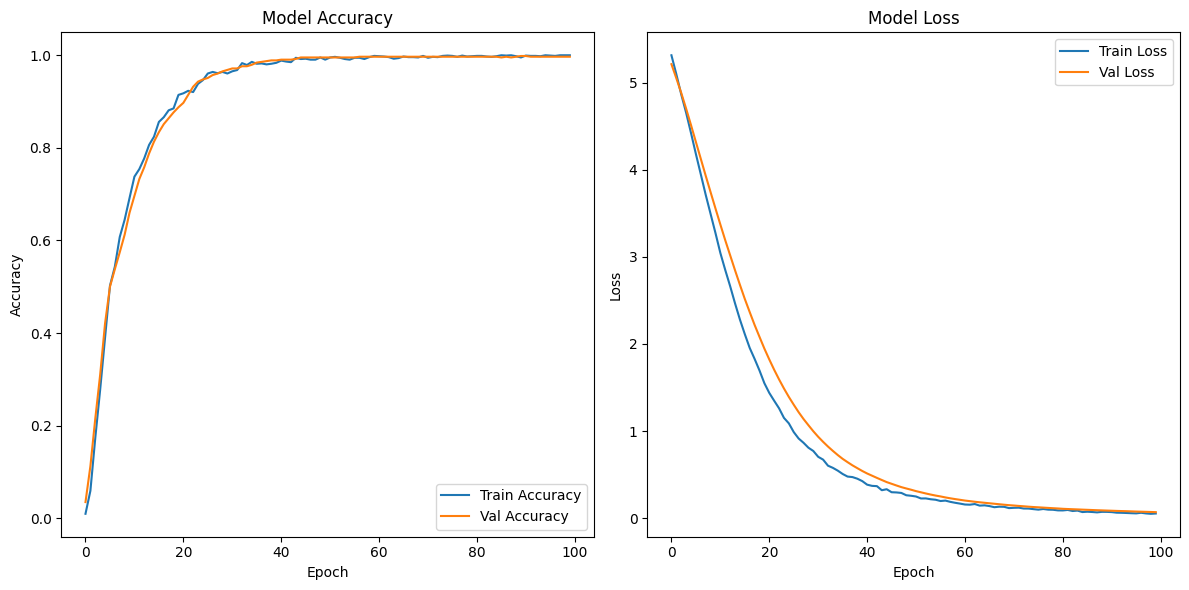

In [ ]:
# For IITD

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',           # Metric to monitor for stopping (can be 'val_accuracy', etc.)
    patience=5,                   # Number of epochs with no improvement before stopping
    min_delta=0.001,              # Minimum change to qualify as an improvement
    mode='auto',                  # 'auto', 'min', 'max'. 'min' for loss, 'max' for accuracy
    verbose=1,                    # Verbosity level (1 for detailed logging)
    restore_best_weights=True     # Restore model weights from the epoch with the best monitored metric
)
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(all_images, y_data_cat, test_size=0.3, random_state=42)

# Create and train the model
model = create_cnn_model()
print("Training the model...")
# history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val), verbose=1)
# Train the model with EarlyStopping
history = model.fit(
    X_train, y_train,
    epochs=100,                    # You can still set a high number of epochs here; early stopping will stop training earlier if no improvement
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    callbacks=[early_stopping]     # Pass the early stopping callback here
)
# Evaluate the model
scores = model.evaluate(X_val, y_val, verbose=0)
print(f"\nValidation Results:")
print(f"Loss = {scores[0]}")
print(f"Accuracy = {scores[1] * 100}%")

import matplotlib.pyplot as plt

# Plotting the accuracy
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting the loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()


# Precision Recall and F1 Score

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


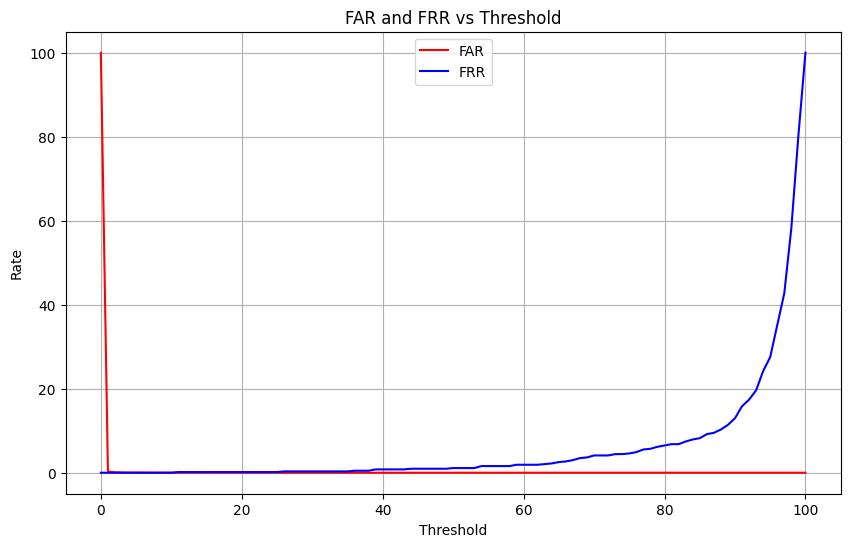

Equal Error Rate (EER): 0.00487 at threshold 10.00




In [ ]:
# Generate predictions and probabilities for validation data
predicted_probs = model.predict(X_val)  # Assuming a binary classification task

# Define ground truth (true labels)
true_labels = np.array(y_val)

# Initialize lists to store FAR and FRR values
thresholds = np.linspace(0, 1, 101)  # Thresholds from 0 to 1 in 0.01 steps
far_values = []
frr_values = []

# Calculate FAR and FRR for each threshold
for threshold in thresholds:
    predicted_labels = (predicted_probs >= threshold).astype(int)

    # Calculate False Acceptances (FA) and False Rejections (FR)
    false_acceptances = np.sum((predicted_labels == 1) & (true_labels == 0))
    false_rejections = np.sum((predicted_labels == 0) & (true_labels == 1))

    # Total negatives and positives
    total_negatives = np.sum(true_labels == 0)
    total_positives = np.sum(true_labels == 1)

    # FAR and FRR
    far = false_acceptances / total_negatives if total_negatives > 0 else 0
    frr = false_rejections / total_positives if total_positives > 0 else 0

    far_values.append(far)
    frr_values.append(frr)

# Plot FAR and FRR
plt.figure(figsize=(10, 6))
plt.plot(thresholds*100, np.array(far_values) * 100, label='FAR', color='red')
plt.plot(thresholds*100, np.array(frr_values) * 100, label='FRR', color='blue')
plt.title('FAR and FRR vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Rate')
plt.legend()
plt.grid()
plt.show()

# Find the Equal Error Rate (EER)
differences = np.abs(np.array(far_values) - np.array(frr_values))
eer_index = np.argmin(differences)
eer_threshold = thresholds[eer_index] * 100
eer = (far_values[eer_index] + frr_values[eer_index]) / 2 * 100

print(f"Equal Error Rate (EER): {eer:.5f} at threshold {eer_threshold:.2f}")

print("\n")



# K-fold Cross-Validation


In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',           # Metric to monitor for stopping (can be 'val_accuracy', etc.)
    patience=5,                   # Number of epochs with no improvement before stopping
    min_delta=0.001,              # Minimum change to qualify as an improvement
    mode='auto',                  # 'auto', 'min', 'max'. 'min' for loss, 'max' for accuracy
    verbose=1,                    # Verbosity level (1 for detailed logging)
    restore_best_weights=True     # Restore model weights from the epoch with the best monitored metric
)

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Set n_splits to the number of folds

# Variables to store the results across folds
val_losses = []
val_accuracies = []

# Loop through each fold
for fold, (train_index, val_index) in enumerate(kf.split(all_images)):
    print(f"\nTraining fold {fold+1}...")

    # Split the data for the current fold
    X_train_fold, X_val_fold = all_images[train_index], all_images[val_index]
    y_train_fold, y_val_fold = y_data_cat[train_index], y_data_cat[val_index]

    # Create and train the model
    model = create_cnn_model()  # Assuming your model creation function
    print(f"Training the model for fold {fold+1}...")

    # Train the model with EarlyStopping
    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=100,                    # You can still set a high number of epochs here; early stopping will stop training earlier if no improvement
        batch_size=32,
        validation_data=(X_val_fold, y_val_fold),
        verbose=1,
        # callbacks=[early_stopping]     # Pass the early stopping callback here
    )

    # Evaluate the model on the validation fold
    scores = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_losses.append(scores[0])
    val_accuracies.append(scores[1])

    print(f"Fold {fold+1} - Validation Loss: {scores[0]} - Validation Accuracy: {scores[1] * 100}%")

# Calculate average performance across all folds
avg_val_loss = np.mean(val_losses)
avg_val_accuracy = np.mean(val_accuracies)

print(f"\nAverage Validation Loss across all folds: {avg_val_loss}")
print(f"Average Validation Accuracy across all folds: {avg_val_accuracy * 100}%")

# Plotting the average loss and accuracy across folds
import matplotlib.pyplot as plt

# Plotting the accuracy
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values for each fold
plt.subplot(1, 2, 1)
for fold in range(len(val_accuracies)):
    plt.plot(history.history['accuracy'], label=f'Fold {fold+1} Train Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'Fold {fold+1} Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plotting the loss
plt.subplot(1, 2, 2)
for fold in range(len(val_losses)):
    plt.plot(history.history['loss'], label=f'Fold {fold+1} Train Loss')
    plt.plot(history.history['val_loss'], label=f'Fold {fold+1} Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Display the plots
plt.tight_layout()
plt.show()



Training fold 1...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the model for fold 1...
Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.0096 - loss: 5.3577 - val_accuracy: 0.0451 - val_loss: 5.1763
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.0628 - loss: 5.0997 - val_accuracy: 0.2185 - val_loss: 4.9913
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.1966 - loss: 4.8580 - val_accuracy: 0.3895 - val_loss: 4.7995
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3568 - loss: 4.6072 - val_accuracy: 0.5226 - val_loss: 4.5934
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.4818 - loss: 4.3510 - val_accuracy: 0.6010 - val_loss: 4.3825
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.5956 - loss: 4.0883 - val_accuracy: 0.6675 - val_loss: 4.1657
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.6527 - loss: 3.8328 - val_accuracy: 0.7197 - val_loss: 3.9480
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.7